Detekce anomálií v EKG signálech

V EKG siglálu zaznamenáváme:

    - P vlnu - která nastává před Q kmitem nebo R vrcholem, normální amplituda P vlny nepřesahuje 0,25 mV
    - Q kmit, První negativní kmit, který může se v komplexu nemusí vyskytovat, vyskytuje se před R vrcholem, trvání nepřesahuje 0.03s, kmit delší než 0,04s jasně poukazuje na jizvu po infarktu myokardu
    - PQ interval - od začátku P vlny do začátku komorového komplexu QRS - Fyziologické hodnoty se pohybují mezi 0,12–0,20 s.
        - Prodloužený P-Q interval znamená delší dobu převodu řídícího impulsu ze síní na komory při poruchách v A-V části převodního systému. Zkrácený PQ interval znamená, že řídící impuls se dostal na převodní systém komor dříve než normálně  protože zpravidla obešel A-V uzel abnormálními spoji převodního systému.
    - PQ úsek - doba mezi koncem P a začátkem Q
    - R vrchol - pozitivní kmit
    - S kmit - jsou negativní kmity komplexu následující za R vrcholem
    - QRS komplex - depolarizace komor(Fyziologicky QRS komplex trvá do 0,11 s.), pro výpočet se mohou použít Sokolowovy indexy
    - T vlna - 
    - QT interval - od začátku QRS komplexu po konec vlny T. Normální hodnoty jsou od 0,25 s do 0,50 s.
    - ST úsek - doba mezi koncem S a začátkem T, Odchylky od normy jsou známkou poruchy repolarizace myokardu. Typické změny ST úseku se objevují v akutní fázi transmurálního infarktu myokardu.
    


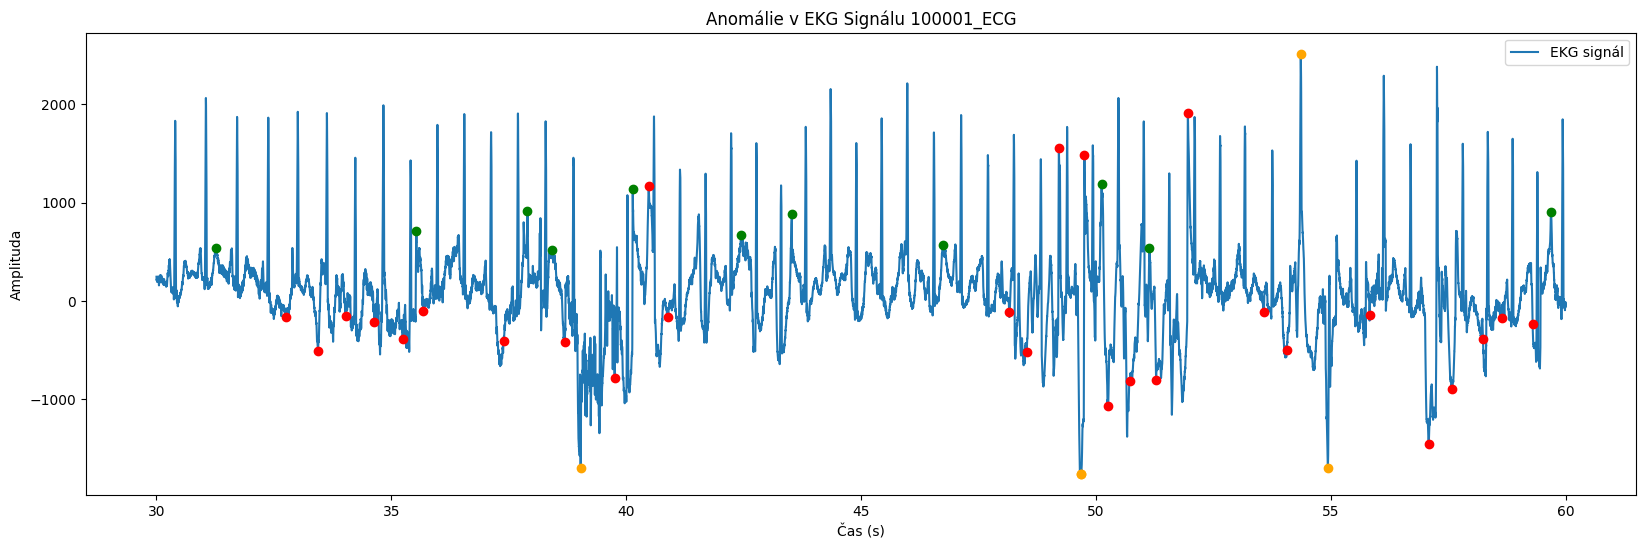

100001_ECG : 
 Vysoké amplitudy R vrcholů:  1 
 Nízké amplitudy:  4 
 P amplitudy nízké:  23 
 P amplitudy vysoké:  4 
 P duration nízký:  0 
 P duration vysoký:  0 
 T amplitudy nízké:  0 
 T amplitudy vysoké:  11 
 T duration nízké:  0 
 T duration vysoké:  0 
 QRS duration nízké:  0 
 QRS duration vysoké:  0 
 Celkem:  43


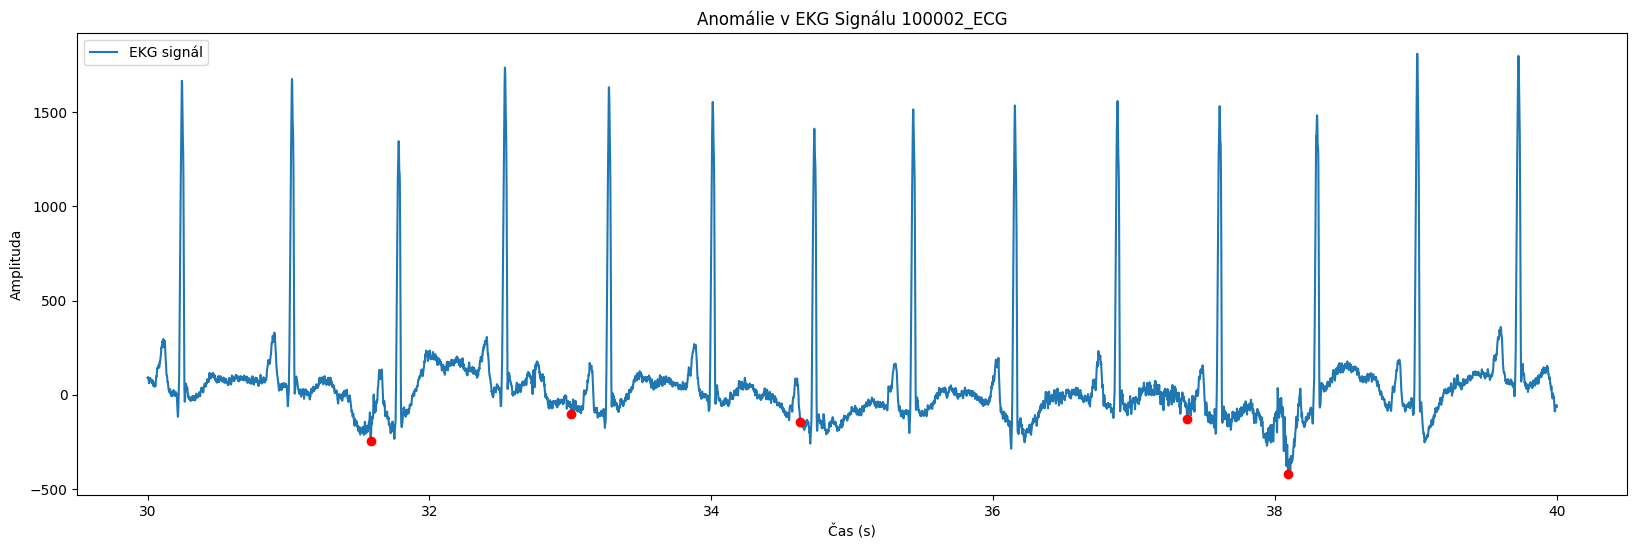

100002_ECG : 
 Vysoké amplitudy R vrcholů:  0 
 Nízké amplitudy:  0 
 P amplitudy nízké:  5 
 P amplitudy vysoké:  0 
 P duration nízký:  0 
 P duration vysoký:  0 
 T amplitudy nízké:  0 
 T amplitudy vysoké:  0 
 T duration nízké:  0 
 T duration vysoké:  0 
 QRS duration nízké:  0 
 QRS duration vysoké:  0 
 Celkem:  5


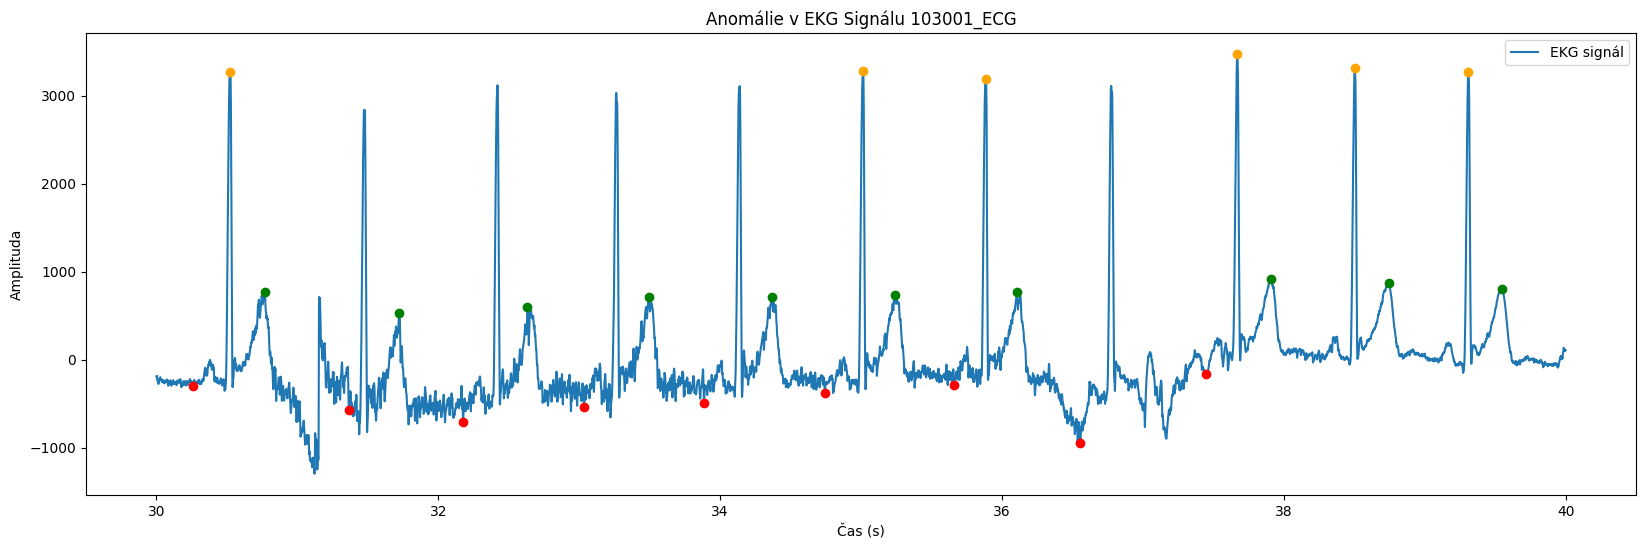

103001_ECG : 
 Vysoké amplitudy R vrcholů:  6 
 Nízké amplitudy:  0 
 P amplitudy nízké:  9 
 P amplitudy vysoké:  0 
 P duration nízký:  0 
 P duration vysoký:  0 
 T amplitudy nízké:  0 
 T amplitudy vysoké:  10 
 T duration nízké:  0 
 T duration vysoké:  0 
 QRS duration nízké:  0 
 QRS duration vysoké:  0 
 Celkem:  25


In [47]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

#detekce anomálií v signálu - způsob jak detekovat tyto úseky + prezentace statistiky výskytu úseků v měřeních
def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

ecg_mereni = Nacti_soubor(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\100001\100001_ECG")

ecg_signal = ecg_mereni.p_signal 
vz_f = ecg_mereni.__dict__['fs']
amplitudy = ecg_signal[:, 0]
start_time = 30
end_time = 60
start_index = int(vz_f*start_time) #vezmu si 30 sekund
end_index = int(vz_f*end_time)
ecg_signal_30_60 = amplitudy[start_index:end_index]
time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) #na začátku vidím nějakou anomálii, tak si signál přesunu o 30 sekund dopředu
#zase si vložím R-peaks finder
def r_peaks_finder(ecg_signal, min_peaks_height, min_distance,test=False):
    r_peaks = [] #seznam, kam si uložím souřadnice vrcholů
    for i in range(1, len(ecg_signal)-1):
        #if ekg_signal[i] > threshold and ekg_signal[i] > ekg_signal[i - 1] and ekg_signal[i] > ekg_signal[i + 1]: peaks.append(i)
        if ecg_signal[i]>min_peaks_height:
            #zkontroluji že hodnota je větší něž okolní hodnoty
            #zde jsem ještě musel přidat podmínku aby to ty vrcholi kontrolovalo o 1 navíc citlivěji, protože mi některé to vynechalo
            if ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+1] or ecg_signal[i]>ecg_signal[i-1] and ecg_signal[i]>ecg_signal[i+2]:
                if len(r_peaks) == 0 or (i-r_peaks[-1]>=min_distance): 
                    r_peaks.append(i)
                elif test: print(f"Vrchol ignorován (příliš blízko): Index {i}, Hodnota {ecg_signal[i]}")
            elif test: print(f"Vrchol ignorován (není lokální maximum): Index {i}, Hodnota {ecg_signal[i]}")
    #print(r_peaks[:20]) #testování
    return r_peaks

def Vypocet_prumerne_frekvence(amplitudy, dolni_mez):
    x_coords = [uV for uV in amplitudy if uV > dolni_mez] #vezmu všechny hodnoty frekvencí, které jsou delší než dolní mez frekvence
    if len(x_coords) > 0: #když měření bude obsahovat nějaké souřadnice
        prumer_x = sum(x_coords) / len(x_coords) #vypočítám si průměrnou hodnotu x vrcholů
        return prumer_x
    else: return 0

#a ted nějaký algoritmus na detekci anomálií, kam bude vstupovat ekg signál, r vrcholy a nějaké limity které se vymykají normě
def detect_anomalies_algoritm(ecg_signal,r_peaks,r_peaks_max,r_peaks_min):
    # nejdřív bychom si měli určit, které anomálie můžou nastávat při ekg měření
    anomalie = {'high_amplitudes': [], 'low_amplitudes': [], "P_amplow": [], "P_amphigh": [], "P_durationlow": [],"P_durationhigh": [], 
                                                            "T_amplow": [], "T_amphigh": [], "T_durationlow": [],"T_durationhigh": [], 
                                                            "QRS_durationlow": [],"QRS_durationhigh": []}
    
    
    # hledání nízkých hodnot
    min_values = np.where(ecg_signal < r_peaks_min)[0] #vezmu si hodnoty, které jsou nižší než minimum
    #projdu hodnoty for cyklem
    for idx in min_values:
        #ujistím se aby to vzalo v daném úseku jenom tu nejnižší hodnotu
        if idx - 50 >= 0 and idx + 50 < len(ecg_signal):
            #Ujistím se, že 50 hodnot kolem nebude menší než hodnota, kterou budu přidávat.
            if ecg_signal[idx]<np.min(ecg_signal[idx+1:idx+50]) and ecg_signal[idx]<np.min(ecg_signal[idx-50:idx-1]):
                #nakonec přidám index a hodnotu do anomálií
                anomalie["low_amplitudes"].append((idx, ecg_signal[idx]))
    

    
    #rozpoznání typů vln podle R vrcholů 
    for r in r_peaks:
        # Detekce P vlny (od -100 do -300)
        p_start = max(0, r - 300)  # Ošetření indexu na začátku signálu
        p_end = r - 100 #určím si start a konec P vlny
        p_segment = ecg_signal[p_start:p_end] #P vlnu si zobrazím jako segment v ekg signálu
        #budou zkoumat velikost P vlny
        if np.max(p_segment) > 1000: #určím si maximalní limit pro P vlnu
            anomalie["P_amphigh"].append((p_start + np.argmax(p_segment), np.max(p_segment))) #uložím index s hodnotou
        elif np.min(p_segment) < -100: #určím si minimální limit pro P vlnu    
            anomalie["P_amplow"].append((p_start + np.argmin(p_segment), np.min(p_segment)))
    
        # Detekce QRS komplexu (od -100 do 100)
        qrs_start = max(0, r - 100)
        qrs_end = min(len(ecg_signal), r + 100)
        qrs_segment = ecg_signal[qrs_start:qrs_end] 
        if np.max(qrs_segment) > r_peaks_max: #detekuji vysoké vrcholy
            anomalie["high_amplitudes"].append((qrs_start + np.argmax(qrs_segment), np.max(qrs_segment)))
        
        # Detekce T vlny (od 100 do 300)
        t_start = r + 100
        t_end = min(len(ecg_signal), r + 300)
        t_segment = ecg_signal[t_start:t_end]
        if len(t_segment)>0:
            #if np.min(t_segment) < -1000: #minimální hranice T vlny
            #    anomalie["T_amplow"].append((t_start + np.argmin(t_segment), np.min(t_segment)))
            if np.max(t_segment) > 500: #maximální hranice T vlny
                anomalie["T_amphigh"].append((t_start + np.argmax(t_segment), np.max(t_segment)))

    return anomalie

# Vykreslení anomálií
def plot_anomalies(time_axis_30_60, ecg_signal_30_60, anomalie, signal_name):
    plt.figure(figsize=(20, 6)) #stanovím si rozměr plotu
    plt.plot(time_axis_30_60,ecg_signal_30_60, label="EKG signál") #vykreslím si signál
    #do signálu budu vykreslovat různé anomálie
    for wave_type, anomaly_types in anomalie.items():
        #nejdřív musím najít anomálii podle názvu a potom jí vykreslím do grafu
        if wave_type.find("amp") != -1: #hledám v seznamu amplitudy
            for idx in anomaly_types: #projdu je for cyklem a podle jejich typu jim přidělím barvu
                if wave_type == "P_amplow" or wave_type == "P_amphigh": color='red'
                elif wave_type == "T_amplow" or wave_type == "T_amphigh": color='green'
                elif wave_type == "QRS_amplow" or wave_type == "QRS_amphigh": color='blue'
                else: color="orange"
                plt.plot(time_axis_30_60[idx[0]], ecg_signal_30_60[idx[0]], linestyle='None', marker='o', color=color)
        #if wave_type.find("duration") != -1: #hledám v seznamu trvání
        #    for idx in anomaly_types:
        #        print("duration anomaly found")
        #        if wave_type == "P_durationlow" or wave_type == "P_durationhigh": color='red'
        #        elif wave_type == "T_durationlow" or wave_type == "T_durationhigh": color='green'
        #        elif wave_type == "QRS_durationlow" or wave_type == "QRS_durationhigh": color='blue'
        #        else: color="darkgreen"
        #        plt.plot(np.linspace(start_time,end_time,len(idx[0])), idx[0], linestyle='-', color=color)
    plt.legend()
    plt.title(f"Anomálie v EKG Signálu {signal_name}")
    plt.xlabel("Čas (s)")
    plt.ylabel("Amplituda")
    plt.show()

dolni_mez = 500 
prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez)
min_peaks_height = prumer_f 
catching_time = 0.5 #určím si čas jak často budu zaznamenávat R vrcholy
min_distance = int(vz_f*catching_time) 

#najdu vrcholy
r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance)
#změřím anomálie
anomalie = detect_anomalies_algoritm(ecg_signal_30_60,r_peaks_30_60,r_peaks_max=2500,r_peaks_min=-1500)
#testování, Funkce, kde si vypíšu si informace o anomáliích.
def print_info(anomalie, signal_name):
    print(signal_name ,': \n', 'Vysoké amplitudy R vrcholů: ',len(anomalie['high_amplitudes']),"\n",'Nízké amplitudy: ',len(anomalie["low_amplitudes"]),"\n",
          'P amplitudy nízké: ',len(anomalie["P_amplow"]),"\n", 'P amplitudy vysoké: ',len(anomalie["P_amphigh"]),"\n", 'P duration nízký: ',len(anomalie["P_durationlow"]),"\n", 'P duration vysoký: ',len(anomalie["P_durationhigh"]),"\n",
          'T amplitudy nízké: ',len(anomalie["T_amplow"]),"\n", 'T amplitudy vysoké: ',len(anomalie["T_amphigh"]),"\n", 'T duration nízké: ',len(anomalie["T_durationlow"]),"\n", 'T duration vysoké: ',len(anomalie["T_durationhigh"]),"\n",
          'QRS duration nízké: ',len(anomalie["QRS_durationlow"]),"\n", 'QRS duration vysoké: ',len(anomalie["QRS_durationhigh"]), '\n Celkem: ', sum(len(value) if isinstance(value,(list)) else 0 for value in anomalie.values()))

plot_anomalies(time_axis_30_60,ecg_signal_30_60,anomalie, signal_name=ecg_mereni.record_name)
print_info(anomalie, signal_name=ecg_mereni.record_name)


#vyzkouším to u jiného ekg měření
def get_signal_measure(file_path): #zase si všechno dám do funkce, abych to mohl vyzkoušet u více měření.
    ecg_mereni = Nacti_soubor(file_path)

    ecg_signal = ecg_mereni.p_signal 
    vz_f = ecg_mereni.__dict__['fs']
    amplitudy = ecg_signal[:, 0]
    #Vezmu si jenom úsek 10 sekund signálu, abych měl větší přehled o tom, jak funguje ta detekce anomálií.
    start_time = 30 
    end_time = 40
    start_index = int(vz_f*start_time) #vezmu si 10 sekund
    end_index = int(vz_f*end_time)
    ecg_signal_30_60 = amplitudy[start_index:end_index] #vezmu amplitudy v daném časovém úseku
    time_axis_30_60 = np.linspace(start_time,end_time,len(ecg_signal_30_60)) #na začátku vidím nějakou anomálii, tak si signál přesunu o 30 sekund dopředu
    dolni_mez = 500 #zvolím si dolní mez od které se bude počítat průměrná ferkvence
    prumer_f = Vypocet_prumerne_frekvence(ecg_signal_30_60, dolni_mez)
    min_peaks_height = prumer_f #dám si průměrnou frekvenci jako minimální výšku vrcholů
    catching_time = 0.5 #pro zpřesnění detekce si určím v ms nějaký detekovací čas
    min_distance = int(vz_f*catching_time) #vynásobím ho se vzorokovací frekvencí
    r_peaks_30_60 = r_peaks_finder(ecg_signal_30_60, min_peaks_height, min_distance) 
    #najdu anomálie v signálu
    anomalie = detect_anomalies_algoritm(ecg_signal_30_60,r_peaks_30_60,r_peaks_max=prumer_f*2.5,r_peaks_min=-2000)
    plot_anomalies(time_axis_30_60,ecg_signal_30_60,anomalie,signal_name=ecg_mereni.record_name)
    #podtím si udělám výpis anomálií
    print_info(anomalie, signal_name=ecg_mereni.record_name)

get_signal_measure(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\100002\100002_ECG")

#změřím další signál
get_signal_measure(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_1\mereni_signalu\103001\103001_ECG")